In [1]:
from torchvision import transforms as tf
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import cv2

import glob, os

/home/taejukwon/anaconda3/envs/textdiffuser/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from utils.new_pipeline import MixSceneTextPipeline

In [1]:
def load_model():
    # pipe = DiffUTEPipeline('cuda:0')
    pipe = MixSceneTextPipeline('cuda:0')
    ckpt = torch.load('./pytorch_model.bin', map_location='cpu')
    pipe.unet.load_state_dict(ckpt)
    return pipe

In [2]:
import gradio as gr
from utils.pipeline import DiffUTEPipeline
from utils.new_pipeline import MixSceneTextPipeline
from Onomatopoeia.Onomato_translation import find_similar_korean_onomatopoeia
from Onomatopoeia.input_similar import find_most_similar_word_from_OCR
import torch
from torchvision import transforms as tf
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import cv2
import glob, os
import easyocr

/home/taejukwon/anaconda3/envs/textdiffuser/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
pipe = load_model()

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-printed and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
pipe.to('inapint')

In [5]:
prompt = "removed masked part"

In [6]:
img = Image.open("/mnt/c/Users/USER/LABis/DiffUTE/figure/전독시2.jpg")

In [7]:
def get_OCR_result(init_img):
    os.environ['CUDA_VISIBLE_DEVICES'] = '0,'
    reader = easyocr.Reader(['ko', 'en'])
    result = reader.readtext(np.array(init_img)) # PIL to cv2 (but RGB is not changed)
    
    return result

def make_mask_image(init_img, mask_text):
    result = get_OCR_result(init_img)
    
    for pts, text, p in result :
        if text == mask_text :
            mask_img = np.zeros_like(init_img)
            cv2.fillConvexPoly(mask_img, np.array(pts, dtype=np.int32), (255, 255, 255))
            break

    return Image.fromarray(mask_img), np.array(pts)
    # return Image.fromarray(mask_img)

In [ ]:
# pipe.sample(init_image=sample_img, mask_image= mask_img, prompt= prompt)

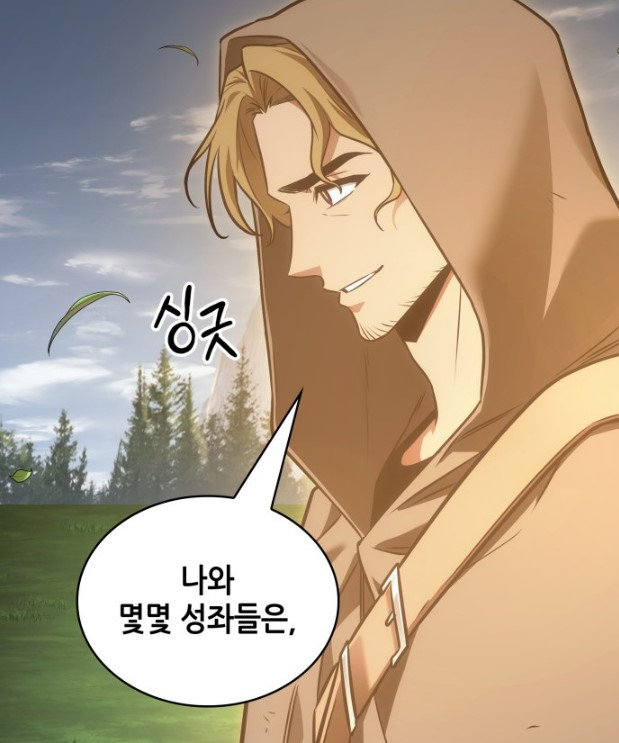

In [8]:
img

In [10]:
from Onomatopoeia.divide import concated_prob_from_image

In [13]:
img_cv = cv2.imread('/mnt/c/Users/USER/LABis/DiffUTE/figure/전독시2.jpg')

In [16]:
output = concated_prob_from_image(img_cv)

In [17]:
output

(['상곳', '나와', '몇몇 성좌들은'],
 [0.5108094379571123, 0.7495466608762762, 0.8416062418594465])

In [22]:
def Decision(image, text):    
    output = concated_prob_from_image(image)
    print(output)
    # i = output.index(text)
    # if output[1][i] > 0.75:
    #     return output[0][i], True
    # else:
    #     return output[0][i], False

    

In [26]:
Decision(img_cv, '나와')

ValueError: tuple.index(x): x not in tuple

In [22]:
def generate_image(init_img, mask_text):
    prompt = "remove masked part"
    # init_img = Image.fromarray(init_img)
    mask_img, pts = make_mask_image(init_img, mask_text)
    
    # crop_init_img, crop_pts = crop_center(init_img, pts)
    # crop_mask_img, crop_pts = crop_center(mask_img, pts)
    init_img = img.resize((512, 512))
    mask_img, pts = make_mask_image(init_img, mask_text)
    mask_img = mask_img.resize((512, 512))
    # w, h = crop_init_img.size
    # image = crop_init_img.resize((512, 512))
    # masked_image = crop_mask_img.resize((512, 512))
    # output_image = pipe.sample(crop_init_img.resize((512, 512)), crop_mask_img.resize((512, 512)), prompt)
    pipe.to('inpaint')
    output = pipe.sample(init_img, mask_img, prompt)
    return output, pts

In [23]:
output_image, pts = generate_image(img, "끼개각")

100%|██████████| 50/50 [00:46<00:00,  1.08it/s]


In [24]:
pts

array([[228, 111],
       [373, 111],
       [373, 188],
       [228, 188]])

In [90]:
from PIL import Image, ImageDraw, ImageFont

font = ImageFont.truetype("./utils/arial.ttf", 50)
draw = ImageDraw.Draw(output_image)
output = draw.textbbox((228, 111), "CREAk", font = font)

In [91]:
def make_mask_coor(input_array):
    x_1, x_2 = input_array[0], input_array[2]
    y_1, y_2 = input_array[1], input_array[3]
    
    return np.array([[x_1, y_1], [x_2, y_1], [x_2, y_2], [x_1, y_2]])

In [92]:
output

(228, 120, 392, 158)

In [93]:
make_mask_coor(output)

array([[228, 120],
       [392, 120],
       [392, 158],
       [228, 158]])

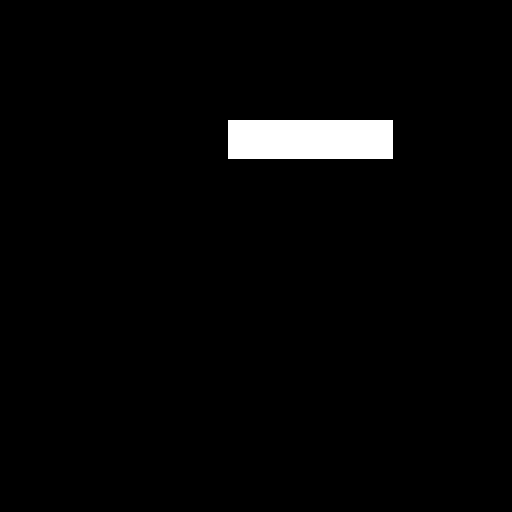

: 

In [94]:
mask_img = np.zeros_like(np.array(img.resize((512, 512))))
cv2.fillConvexPoly(mask_img, np.array(make_mask_coor(output), dtype=np.int32), (255, 255, 255))
Image.fromarray(mask_img)

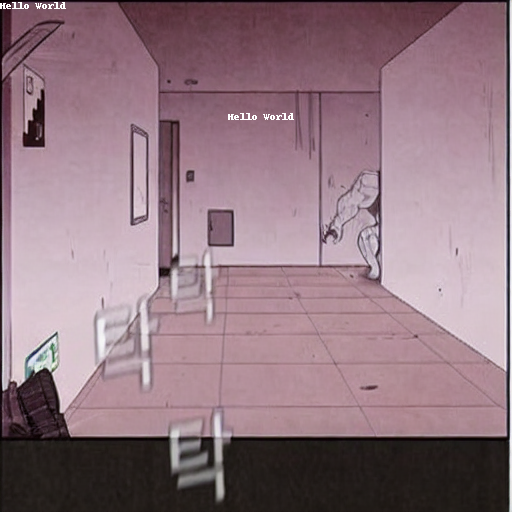

In [55]:
output_image